In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/t5embeds/train_ids.npy
/kaggle/input/t5embeds/test_embeds.npy
/kaggle/input/t5embeds/train_embeds.npy
/kaggle/input/t5embeds/test_ids.npy
/kaggle/input/cafa5-test/id_seq_aspect_tokenized.csv
/kaggle/input/cafa5-test/model_CNN_LSTM.h5
/kaggle/input/cafa5-test/predictions.npy
/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-5-protein-function-prediction/IA.txt
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo


In [2]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import progressbar

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Load Data

In [3]:
#Load Data 
#Terms for each protein fold
train_terms = pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv',sep='\t')
#Embeddings for each aminoacid_sequence
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')
#Protein ID's for the embeddings
train_id = np.load('/kaggle/input/t5embeds/train_ids.npy')

In [4]:
train_id.shape,train_embeddings.shape

((142246,), (142246, 1024))

In [5]:
# Convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
train_df['ID'] = train_id

## Exploratory Analysis

In [6]:
train_terms

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO
...,...,...,...
5363858,X5L565,GO:0050649,MFO
5363859,X5L565,GO:0016491,MFO
5363860,X5M5N0,GO:0005515,MFO
5363861,X5M5N0,GO:0005488,MFO


In [7]:
train_terms['term'].unique().shape

(31466,)

In [8]:
train_df

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024,ID
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070,P20536
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430,O73864
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234,O95231
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917,A0A0B4J1F4
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054,P54366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.032529,0.032490,0.026844,0.007486,-0.019346,0.033527,0.048294,-0.091146,0.007092,0.008843,...,-0.037237,-0.022644,-0.055443,0.002142,0.006521,-0.026665,-0.002415,0.016886,0.004104,A0A286YAI0
142242,0.056026,0.035470,0.021987,0.028443,-0.001087,0.020100,-0.010549,-0.049460,0.027347,-0.028113,...,-0.030632,-0.038549,-0.011747,0.060145,0.003906,-0.031132,0.003377,-0.027095,-0.015910,A0A1D5NUC4
142243,0.016918,0.041331,0.000793,-0.005990,-0.039993,0.056007,-0.013786,-0.076081,0.006320,-0.002054,...,-0.037351,0.008763,-0.051209,0.028266,0.009462,0.019854,0.008808,0.006481,-0.013350,Q5RGB0
142244,0.061252,0.083402,0.044025,0.047916,0.024477,0.035183,-0.016680,-0.043163,-0.045596,-0.029994,...,0.020183,-0.066376,0.058274,0.056035,-0.002282,-0.013941,0.001384,-0.047546,0.010124,A0A2R8QMZ5


In [9]:
#Number of different proteins with the same aminoacid sequence embedding 
df_duplicated = train_df[train_df.loc[:, train_df.columns != 'ID'].duplicated(keep=False)]
#Flag the pairs 
df_duplicated['DuplicateGroup'] = df_duplicated.groupby([col for col in df_duplicated.columns]).ngroup()

/tmp/ipykernel_20/1807187720.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicated['DuplicateGroup'] = df_duplicated.groupby([col for col in df_duplicated.columns]).ngroup()


In [10]:
print(df_duplicated.shape[0])

6092


In [11]:
#Collect all terms of a EntryID inside one row through a list
df_duplicated_terms = train_terms[train_terms['EntryID'].isin(df_duplicated['ID'])].groupby('EntryID')['term'].apply(list).reset_index(name='terms_collected')
df_duplicated_terms['duplicated_sequence_group'] = df_duplicated_terms.merge(df_duplicated, left_on='EntryID', right_on='ID')['DuplicateGroup']

In [12]:
df_duplicated_terms

,EntryID,terms_collected,duplicated_sequence_group
0,A0A023T787,"[GO:0005654, GO:0005622, GO:0031981, GO:004322...",2827
1,A0A024QYT6,"[GO:0005794, GO:0005622, GO:0043229, GO:004322...",4288
2,A0A024QYX0,"[GO:0005622, GO:0043229, GO:0043226, GO:011016...",3453
3,A0A024QYX2,"[GO:0005622, GO:0031981, GO:0043226, GO:000573...",632
4,A0A024QYX3,"[GO:0005622, GO:0031981, GO:0043229, GO:004322...",1951
...,...,...,...
6087,X5DQN9,"[GO:0005622, GO:0031981, GO:0043229, GO:004322...",3375
6088,X5DR03,"[GO:0005829, GO:0005622, GO:0110165, GO:004517...",3393
6089,X5DR09,"[GO:0005622, GO:0031981, GO:0043229, GO:004322...",1237
6090,X5DR79,"[GO:0005622, GO:0031981, GO:0043226, GO:004323...",958


In [13]:
#Number of the same amnoacid sequence and all the same go-terms
df_duplicated_terms['terms_collected'] = df_duplicated_terms['terms_collected'].apply(tuple)
df_dp_count = df_duplicated_terms[df_duplicated_terms[['terms_collected','duplicated_sequence_group']].duplicated(keep=False)] #Count the number of proteins with same sequence and same go-terms

In [14]:
#Different proteins that have different functions although having the same sequence
df_dp_count

,EntryID,terms_collected,duplicated_sequence_group


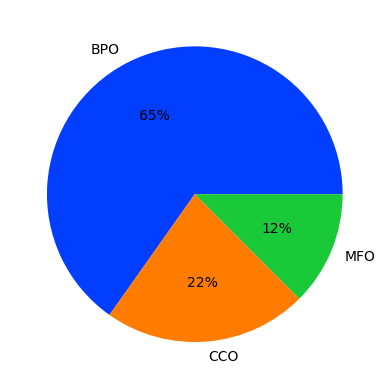

In [15]:
#Distribution betwen aspects
pie_df = train_terms['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [16]:
from Bio import SeqIO

# Specify the path to your FASTA file
fasta_file = '/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta'

# Read the FASTA file
sequences = []
for record in SeqIO.parse(fasta_file, "fasta"):
    # Access the sequence ID and sequence data
    sequence_id = record.id
    sequence_data = record.seq

    # Add the sequence to the list
    sequences.append((sequence_id, sequence_data))

In [17]:
len(sequences), sequences[0],sequences[0][1]

(142246,
 ('P20536',
  Seq('MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIPDKFFIQLK...FIY')),
 Seq('MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIPDKFFIQLK...FIY'))

## Preparing Data

In [18]:
# Set the limit for label
num_of_labels = 1500
train_size = train_id.shape[0] # len(X)

In [19]:
from keras.utils import pad_sequences

# Define the dictionary mapping for tokenization
amino_acid_dict = {
    'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8,
    'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16,
    'T': 17, 'W': 18, 'Y': 19, 'V': 20, 'B': 21, 'Z': 22, 'X': 23, 'U': 24,
    'O': 25
}
amnoacid_sequences = []

# Define the maximum sequence length
max_sequence_length = 400

# Loop through each label
for sequence in sequences:
#     print(sequence[1])
    # Convert sequences to integer tokens
    tokenized_seq = [amino_acid_dict[aa] for aa in sequence[1]]
    
    amnoacid_sequences.append(tokenized_seq)
    
# Pad or truncate sequences to the desired length
amnoacid_sequences = pad_sequences(amnoacid_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0)

In [20]:
amnoacid_sequences.shape

(142246, 400)

In [21]:
# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

# Setup progressbar settings.
bar = progressbar.ProgressBar(maxval=num_of_labels, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# Create an empty dataframe of required size for storing the labels,
train_labels = np.zeros((train_size ,num_of_labels))
series_train_protein_ids = pd.Series(train_id)

# Loop through each label
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    
    # Progress bar percentage increase
    bar.update(i+1)

# Notify the end of progress bar 
bar.finish()

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

[========================================================================] 100%


(142246, 1500)


In [22]:
# Extract input features and labels from the DataFrame
features_input = train_df.loc[:, train_df.columns != 'ID'].values  # Extract the values from the DataFrame
labels_input = labels_df.values  # Extract the label column


In [23]:
features_input

array([[ 0.04948843, -0.03293516,  0.03247323, ..., -0.04353154,
         0.0964628 ,  0.07306959],
       [-0.04461636,  0.06492499, -0.08026284, ...,  0.02672353,
         0.02787905, -0.04842958],
       [-0.02012804, -0.04977943,  0.00789446, ..., -0.03610279,
         0.00769301,  0.10623412],
       ...,
       [ 0.01691809,  0.04133058,  0.00079253, ...,  0.0088079 ,
         0.00648063, -0.01334958],
       [ 0.06125151,  0.08340203,  0.0440247 , ...,  0.00138361,
        -0.04754627,  0.01012351],
       [ 0.02160021,  0.06516985,  0.07492343, ...,  0.0496657 ,
        -0.01987522,  0.04471432]])

In [24]:
#Eval in test data 
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


## Tryng a CNN-LSTM

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, Dropout, Add,Input, Embedding
from keras.layers import LeakyReLU
import tensorflow as tf


# Use MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Create a sequential model
    model_CNN_LSTM = Sequential()
    
    # Add a Conv1D layer for spatial pattern detection
    model_CNN_LSTM.add(Conv1D(32, kernel_size=3, input_shape = (1024,1), activation='LeakyReLU'))
    model_CNN_LSTM.add(MaxPooling1D(pool_size=2))
    
    # Add an LSTM layer for sequence modeling
    model_CNN_LSTM.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
    
    # Add another Dense layer for non-linear transformations
    model_CNN_LSTM.add(Dense(128, activation='LeakyReLU'))

    # Add a fully connected layer for classification
    model_CNN_LSTM.add(Dense(1500, activation='sigmoid'))
    
    # Compile the model
    model_CNN_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    model_CNN_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1022, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 511, 32)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1500)              193500    
                                                                 
Total params: 226,780
Trainable params: 226,780
Non-trainable params: 0
__________________________________________________

In [26]:
import tensorflow as tf

# Check if GPU devices are available
physical_devices = tf.config.list_physical_devices('GPU')
num_gpus = len(physical_devices)
print("Number of available GPUs:", num_gpus)


Number of available GPUs: 0


In [27]:
if num_gpus < 2:
    print("Not enough GPUs available. Training on a single GPU.")
    history_CNN = model_CNN_LSTM.fit(features_input, labels_input, epochs=10, batch_size=1024)# Train the model with GPU acceleration
else:
    #Use MirroredStrategy for multi-GPU training
    with strategy.scope():
        history_CNN = model_CNN_LSTM.fit(features_input, labels_input, epochs=10, batch_size=1024)# Train the model with GPU acceleration

Not enough GPUs available. Training on a single GPU.
Epoch 1/10
139/139 [==============================] - 665s 5s/step - loss: 0.1713 - accuracy: 0.4505
Epoch 2/10
139/139 [==============================] - 640s 5s/step - loss: 0.0781 - accuracy: 0.5099
Epoch 3/10
139/139 [==============================] - 650s 5s/step - loss: 0.0781 - accuracy: 0.4804
Epoch 4/10
139/139 [==============================] - 642s 5s/step - loss: 0.0781 - accuracy: 0.4483
Epoch 5/10
139/139 [==============================] - 645s 5s/step - loss: 0.0781 - accuracy: 0.4923
Epoch 6/10
139/139 [==============================] - 644s 5s/step - loss: 0.0781 - accuracy: 0.4831
Epoch 7/10
139/139 [==============================] - 643s 5s/step - loss: 0.0781 - accuracy: 0.5000
Epoch 8/10
139/139 [==============================] - 655s 5s/step - loss: 0.0781 - accuracy: 0.5162
Epoch 9/10
139/139 [==============================] - 640s 5s/step - loss: 0.0780 - accuracy: 0.4715
Epoch 10/10
139/139 [=================

<Axes: title={'center': 'Accuracy'}>

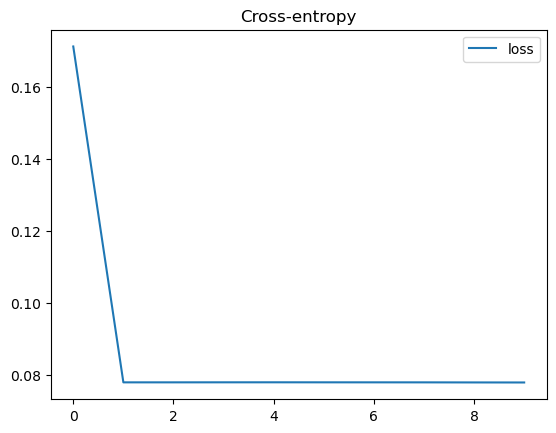

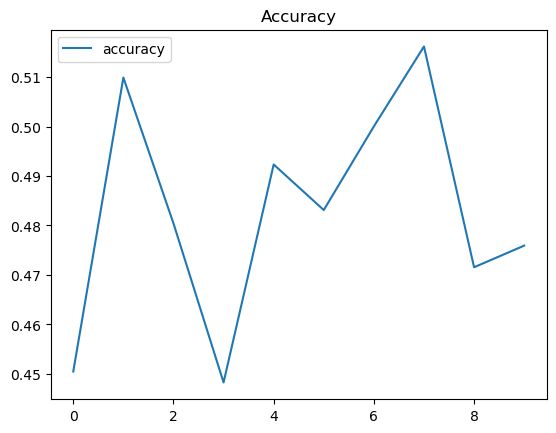

In [28]:
history_df = pd.DataFrame(history_CNN.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy']].plot(title="Accuracy")

In [29]:
from tensorflow.keras.models import save_model
model_CNN_LSTM.save("model_CNN_LSTM.h5")

In [30]:
from tensorflow.keras.models import load_model
model_CNN_LSTM = load_model("/kaggle/input/cafa5-test/model_CNN_LSTM.h5")

In [31]:
import numpy as np
import pandas as pd

test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


In [32]:
predictions =  model_CNN_LSTM.predict(test_df)

4434/4434 [==============================] - 347s 78ms/step


In [33]:
import gc
gc.collect()

7444

In [34]:
predictions

array([[0.64271486, 0.6281419 , 0.63143694, ..., 0.00319658, 0.00307495,
        0.00232623],
       [0.64264005, 0.6281092 , 0.6313687 , ..., 0.00321077, 0.00308915,
        0.00233714],
       [0.64228445, 0.6279149 , 0.63104105, ..., 0.00326024, 0.00313713,
        0.00237442],
       ...,
       [0.642946  , 0.62827134, 0.63181514, ..., 0.00314293, 0.00302077,
        0.00228507],
       [0.6432466 , 0.62848234, 0.6320897 , ..., 0.00309953, 0.00297868,
        0.00225217],
       [0.6428515 , 0.6283023 , 0.63177884, ..., 0.00315423, 0.00303144,
        0.00229298]], dtype=float32)

In [35]:
np.save("predictions.npy", predictions)

In [36]:
import numpy as np
import pandas as pd

predictions = np.load("/kaggle/input/cafa5-test/predictions.npy")
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
train_terms = pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv',sep='\t')

In [37]:
predictions.shape[1]

1500

In [38]:
test_protein_ids.shape

(141865,)

In [39]:
# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
num_of_labels = 1500
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

In [40]:
len(labels)

1500

In [41]:
df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])

In [42]:
for i in test_protein_ids:
    print(i)
    break

Q9CQV8


In [43]:
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions.shape[1]   

In [44]:
len(l)

212797500

In [45]:
df_submission['Protein Id'] = l

In [46]:
df_submission['GO Term Id'] = labels * predictions.shape[0]

In [47]:
df_submission['Prediction'] = predictions.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")